# Visualizing trade networks on world map

Use this notebook as a tutorial on how to draw a network with a real world basemap.

### dependencies

In [ ]:
import matplotlib.pyplot as plt
import contextily as cx

import networkx as nx
import pandas as pd

from pathlib import Path
import sys, os

%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
project_root = Path.cwd().parent
sys.path.append(str(project_root))
data = project_root / 'data'
print(f"Project root directory: {project_root}")
print(f"Data directory: {data}")

load_dotenv()

from scripts.viz_utils import *
from scripts.data_utils import load_network_data
from IPython.display import Markdown, display

Project root directory: /home/dmtr/code/archeo-geo-graph
Data directory: /home/dmtr/code/archeo-geo-graph/data


## Loading data - Querying a specific city - Mytilini

In [2]:
query = 'Mytilini'
nodes, edges = load_network_data(century=15, query_node=query)
print('Edges')
display(Markdown(edges.to_markdown()))
print('Nodes with coordinates')
display(Markdown(nodes.to_markdown()))

Edges


|    | source             | target   |   quantity |   percent_imports |   percent_all_pottery |
|---:|:-------------------|:---------|-----------:|------------------:|----------------------:|
| 63 | Northwest_Anatolia | Mytilini |          7 |              87.5 |                  16.9 |
| 66 | Levant             | Mytilini |          1 |              12.5 |                   2.4 |

Nodes with coordinates


|    | Node               |   latitude |   longitude |
|---:|:-------------------|-----------:|------------:|
|  0 | Northwest_Anatolia |    39.9939 |     29.9042 |
|  1 | Levant             |    34      |     36      |
|  2 | Mytilini           |    39.1077 |     26.5553 |

## Plotting the network using real-world coordinates

Coordinates were obtained by hand from google maps - certain general regions such as the Levant aren't discreet locations present in most datasets.

### initialize the graph object modelling the network

In [3]:
# instantiate the graph object modeling the network
G = nx.from_pandas_edgelist(edges, 
                             source='source',
                             target='target',
                             edge_attr=True,
                             create_using=nx.DiGraph())

### initialize the plot

(29.0, 44.99395)

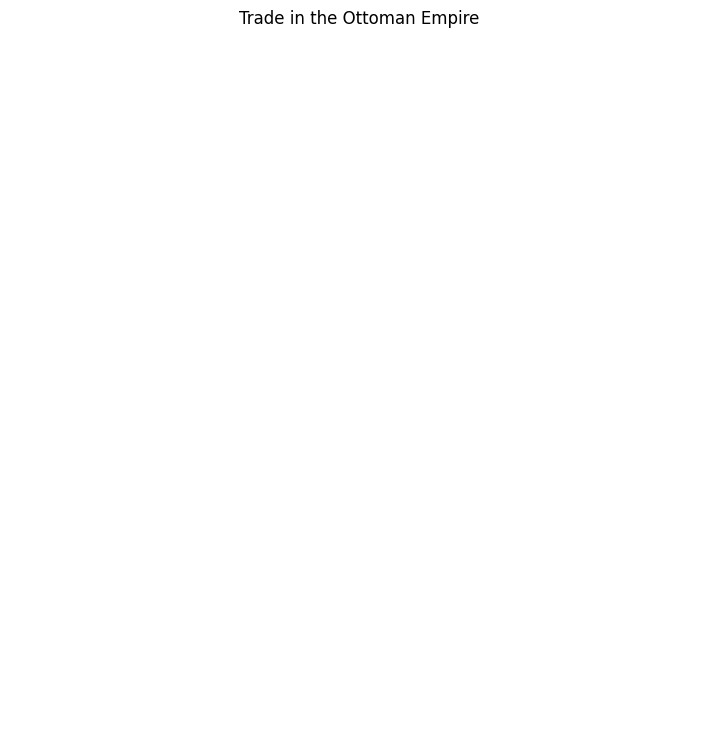

In [4]:
# define plt figure - set the limits of the map before adding the basemap for best results
xlim = nodes.min().longitude - 5, nodes.max().longitude + 5
ylim = nodes.min().latitude - 5, nodes.max().latitude + 5
fig, ax = plt.subplots(figsize=(9, 9))
ax.set_title("Trade in the Ottoman Empire")
ax.axis("off")
ax.set_xlim(xlim)
ax.set_ylim(ylim)

### Plot the network nodes

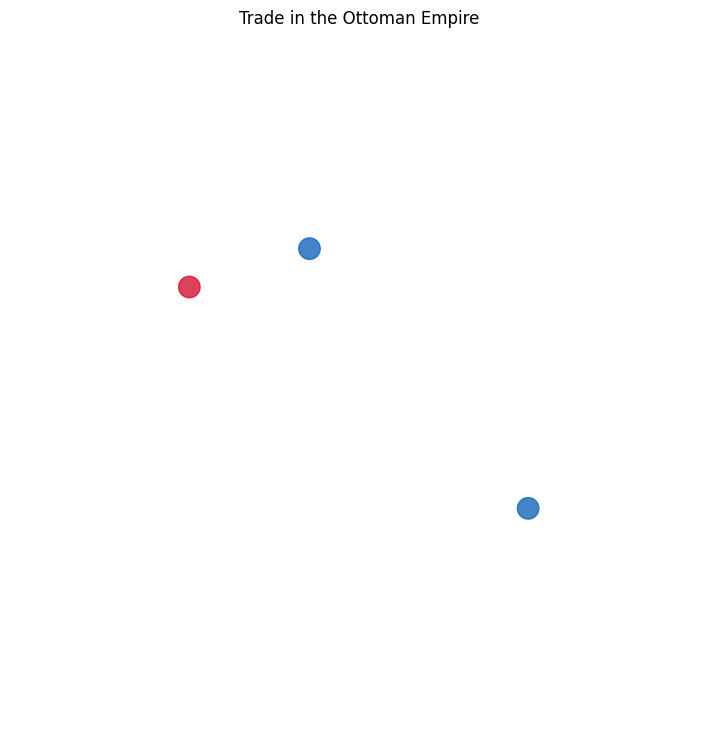

In [5]:
# transform the nodes coordinates dataframe to a dictionary
# ready to be ingested by the plotting function
positions = nodesDF_to_positions(nodes)

# generate color lists based on in-degrees and out-degrees
node_colors = generate_node_color_list(G)

nx.draw_networkx_nodes(G, positions,
                            ax = ax,
                            node_color=node_colors,
                            node_size=240,
                            alpha=0.8
                            )
fig

### Draw network edges

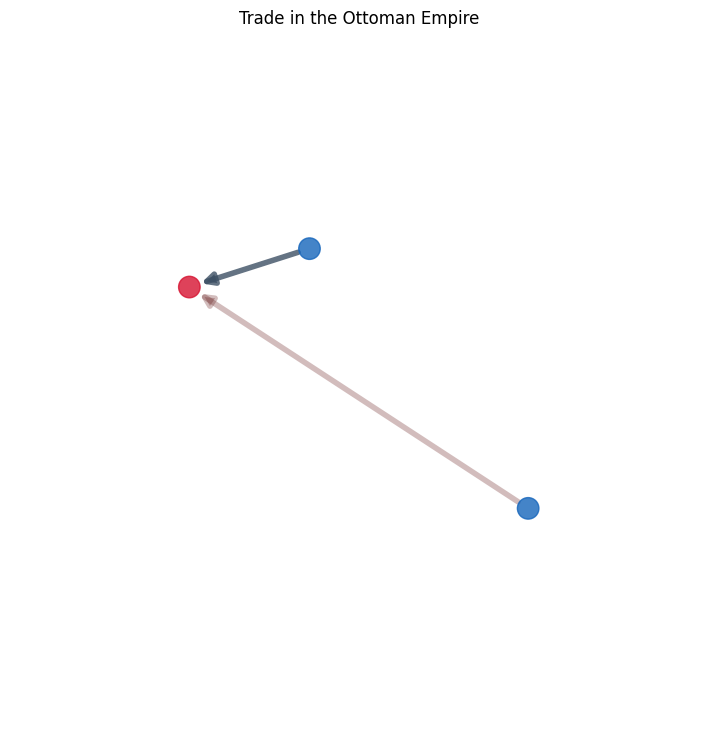

In [6]:
# generate colors based on their source
edge_colors = generate_edge_colors(G)

# generate edge alphas based on the weight metric 
edge_alphas = generate_edge_alphas(edges)

nx.draw_networkx_edges(G, positions,
                            ax=ax,
                            edge_color=edge_colors,
                            width=4,
                            alpha=edge_alphas,
                            arrows=True,
                            arrowsize=17
                        )
fig

### Draw node labels

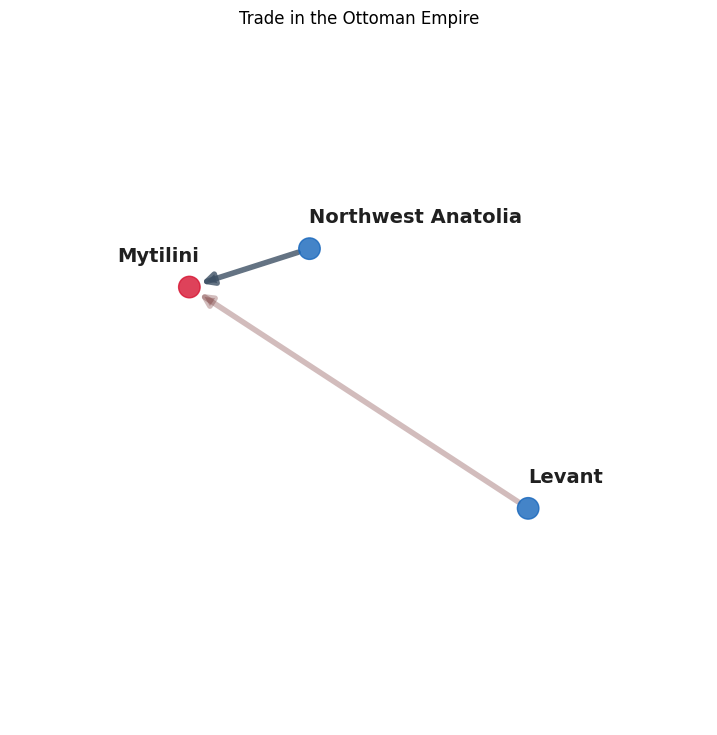

In [7]:
# replace simplified labels with proper labels using special characters
labels_to_draw = generate_proper_labels(G)

# obtain positions for labels - tweak offsets to achieve visibility
label_positions = nodesDF_to_positions(nodes, 
                                        x_offset=-2,
                                        y_offset=0.5,
                                        apply_x_offset_to=['Mytilini'],
                                        apply_y_offset_to='all')

nx.draw_networkx_labels(G, label_positions,
                            labels=labels_to_draw,
                            ax=ax,
                            font_size=14,
                            font_color=('#202020'),
                            font_weight='bold',
                            horizontalalignment='left',
                            verticalalignment='bottom'
                        )
fig

### Draw edge weights

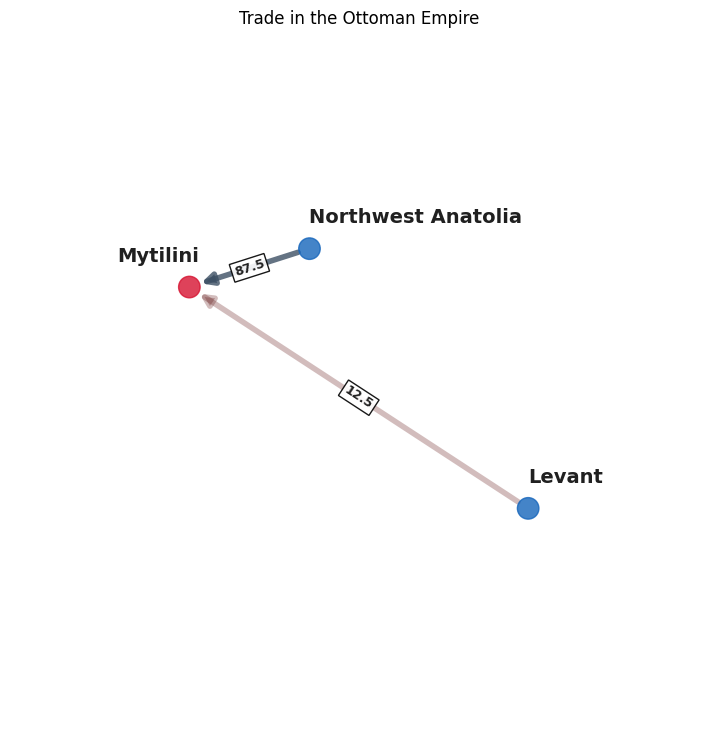

In [8]:
# get the positions of nodes
edge_label_positions = nodesDF_to_positions(nodes) #, x_offset= -42, y_offset = 2.2)
# select the weight feature
weight_feature = 'percent_imports'
# get the actual labels
edge_labels = nx.get_edge_attributes(G, weight_feature)
nx.draw_networkx_edge_labels(G, 
                                pos=edge_label_positions,
                                ax=ax,
                                edge_labels=edge_labels,
                                font_size=9,
                                font_color=('#202020'), 
                                font_weight='bold',
                                # horizontalalignment='left',
                                # verticalalignment='center', 
                                bbox={'facecolor': 'white', 'alpha': 0.9, 'pad': 2}
                            )
fig

### Finally - add the basemap

We'll be using Stamen's Terrain background, provided via stadia's API.
In order to use their API you need to register on https://stadiamaps.com/ and obtain an API key.
You can then put that key in a `.env` file in the root of the project.
Consult the `.env.example` file for the expected structure.

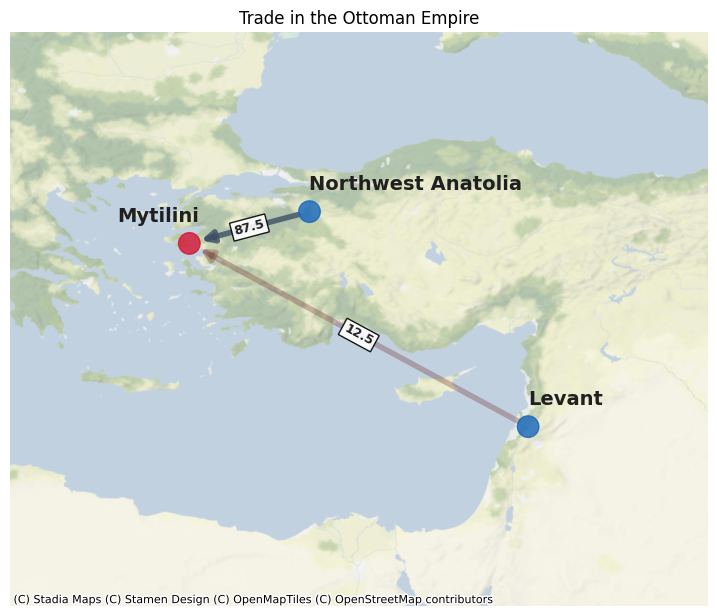

<Figure size 640x480 with 0 Axes>

In [9]:
provider = cx.providers.Stadia.StamenTerrainBackground(api_key=os.getenv('STAMEN_API_KEY'))
provider["url"] = provider["url"] + "?api_key={api_key}"
cx.add_basemap(ax, crs='WGS84', source=provider, zoom='auto', alpha=0.6)

fig

### Saving the figure to a png

In [10]:
fig.savefig(project_root / 'figures' / f'{query}_network.png', dpi=200, bbox_inches='tight')

### Bonus - adjusting the figure 

If one of your labels (City/region/node names) are cut off - you can adjust the figure's xlim and ylim.

current figure's horizontal limits: (21.55529, 41.0)
new horizontal limits: (21.55529, 46.0)


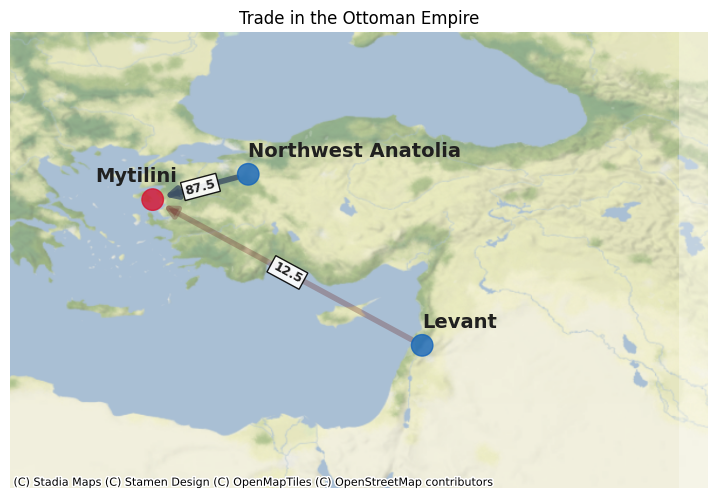

<Figure size 640x480 with 0 Axes>

In [11]:
current_xlim = ax.get_xlim()
print(f"current figure's horizontal limits: {current_xlim}")
new_xlim = (current_xlim[0], current_xlim[1] + 5)
print(f"new horizontal limits: {new_xlim}")

# set the new limits
ax.set_xlim(new_xlim)
# reload the basemap
cx.add_basemap(ax, crs='WGS84', source=provider, zoom='auto', alpha=0.6)
fig

the same can be achieved with much more concise syntax using:

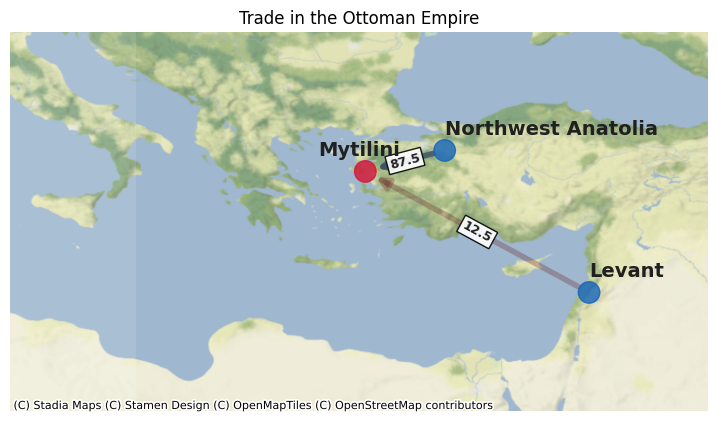

<Figure size 640x480 with 0 Axes>

In [12]:
# set new horizontal figure limits
ax.set_xlim(ax.get_xlim()[0] - 10, ax.get_xlim()[1] - 5)
# reload basemap
cx.add_basemap(ax, crs='WGS84', source=provider, zoom='auto', alpha=0.6)
fig